In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import timeit
import math
import random
from mpmath import *
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
#import xarray

In [2]:
wfriend = pd.read_csv("../Data_Sets/weeplaces/weeplaces/weeplace_friends.csv")
wfriend = wfriend.sort_values(by = ['userid1'])

In [3]:
#wf = pd.read_csv("../Data_Sets/weeplaces/weeplaces/weeplace_checkins_scrubbed_Reordered_DistinctLocs.csv")
wf = pd.read_csv("../Data_Sets/weeplaces/weeplaces/weeplace_checkins_scrubbed_Reordered_DistinctLocs_QPiRog2.csv")

In [4]:
'''Users who have more than 15 friends and less that 130 friends'''
usrs = [wfriend.groupby('userid1').count()[(wfriend.groupby('userid1').count()['userid2'] < 130) & (wfriend.groupby('userid1').count()['userid2'] >= 15)].index.to_list()]
wfriend2 = wfriend[wfriend['userid1'].isin(usrs[0])]

In [5]:
usrsMut = wf[wf['userid'].isin(usrs[0])].groupby('userid').count().index.to_list()
wfriend3 = wfriend[wfriend['userid1'].isin(usrsMut)]

In [6]:
wf.shape
wf[wf['userid'].isin(usrs[0])].shape
print('After scrubbing users with 15 < numfriends < 130, the number of data points shrinks from ' + str(wf.shape[0]) + 
      ' to ' + str(wf[wf['userid'].isin(usrs[0])].shape[0]) + ' points')

After scrubbing users with 15 < numfriends < 130, the number of data points shrinks from 7135528 to 1398438 points


In [7]:
'''Finds pdf of number of friends a user has in the friendship network'''
NumFriends = wfriend.groupby('userid1').count()['userid2'].to_list()
NumFriendsHist = np.histogram(NumFriends,np.append(np.linspace(1,25,25),np.logspace(1.5,2.1)))
NumFriendsCDF = [np.cumsum(NumFriendsHist[0]),NumFriendsHist[1]]

In [8]:
def notnormpowerlaw(rdata,A,alpha):
    return A*rdata**(-alpha)

def lognotnormpowerlaw(rdata,A,alpha):
    return np.log(A) - alpha*np.log(rdata)

def levyflightshift(rdata,rmin,r0, beta):
    return beta*(rmin+r0)**beta*(1/(rdata+r0))**(beta+1)

def loglevyflightshift(rdata,rmin,r0, beta):
    return np.log(beta)+beta*np.log(rmin+r0)-(beta+1)*np.log(rdata+r0)

In [9]:
'''Fits for the pdfs of Number of Friends'''
NumFriendsHistFit = curve_fit(lognotnormpowerlaw,NumFriendsHist[1][1:],np.log(NumFriendsHist[0]/(np.diff(NumFriendsHist[1])*np.sum(NumFriendsHist[0]/np.diff(NumFriendsHist[1])))))
NumFriendsHistFitLF = curve_fit(loglevyflightshift,NumFriendsHist[1][1:],np.log(NumFriendsHist[0]/(np.diff(NumFriendsHist[1])*np.sum(NumFriendsHist[0]/np.diff(NumFriendsHist[1])))))

In [10]:
print('There are ' + str(len(wfriend.groupby('userid1').head(1)['userid2'].to_list())) + ' users in the unscrubbed friendship network')
print('The average number of friends a user has in the original friendship network was ' + str((wfriend.groupby('userid1').count()['userid2'].mean())))
print('The pdf of number of friends a user has can be approximated by a powerlaw distribution with alpha = ' + str(NumFriendsHistFit[0][1]))
print('From the cdf of number of friends, we can see that 90% of users have fewer than 15 friends, implying we must do heavy scrubbing of the data')
print('There are ' + str(len(usrs[0])) + ' users in the friendship network with between 15 and 130 friends')
print('Of those, there are ' + str(len(usrsMut)) + ' users that are also in the location network, so we use those users')
print('The average number of friends a user has is ' + str(wfriend3.groupby('userid1').count()['userid2'].mean()))


There are 16021 users in the unscrubbed friendship network
The average number of friends a user has in the original friendship network was 7.485799887647462
The pdf of number of friends a user has can be approximated by a powerlaw distribution with alpha = 2.483223248103188
From the cdf of number of friends, we can see that 90% of users have fewer than 15 friends, implying we must do heavy scrubbing of the data
There are 1844 users in the friendship network with between 15 and 130 friends
Of those, there are 1579 users that are also in the location network, so we use those users
The average number of friends a user has is 28.46041798606713


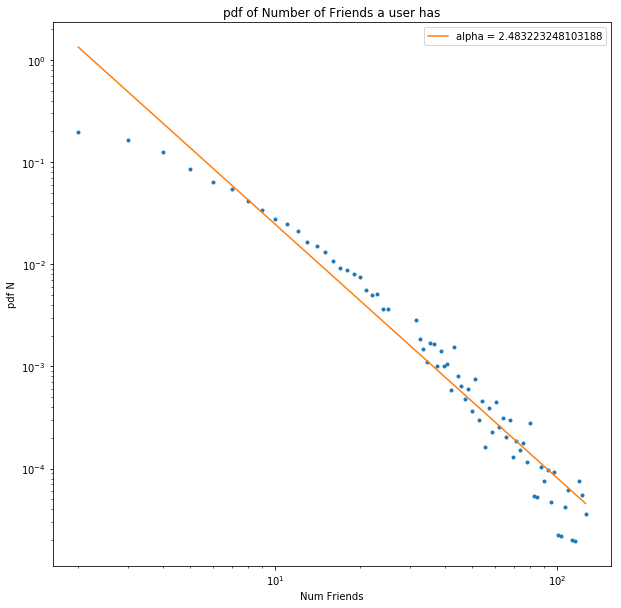

In [12]:
'''All Radii of Gyration pdfs for all the categories'''
fig=plt.figure(figsize=(10, 10))
plt.plot(NumFriendsHist[1][1:], NumFriendsHist[0]/(np.diff(NumFriendsHist[1])*np.sum(NumFriendsHist[0])), '.')
plt.plot(NumFriendsHist[1][1:], notnormpowerlaw(NumFriendsHist[1][1:],NumFriendsHistFit[0][0],NumFriendsHistFit[0][1]), '-', label = 'alpha = ' + str(NumFriendsHistFit[0][1]))
plt.title('pdf of Number of Friends a user has')
plt.ylabel('pdf N')
plt.xlabel('Num Friends')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

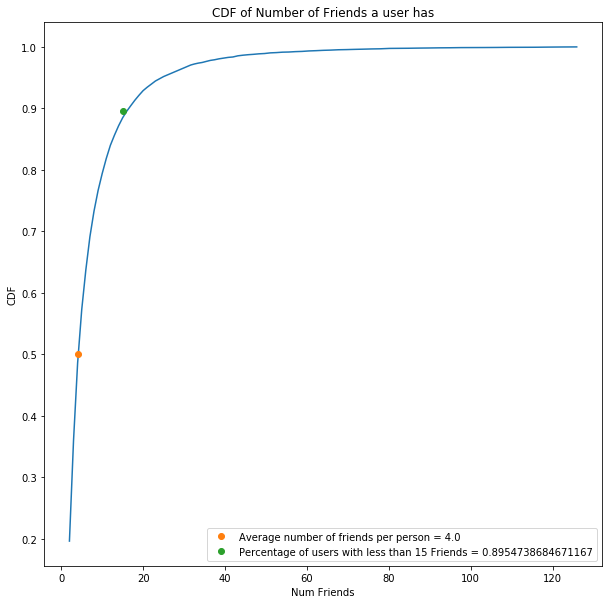

In [13]:
'''All Radii of Gyration pdfs for all the categories'''
fig=plt.figure(figsize=(10, 10))
plt.plot(NumFriendsCDF[1][1:], NumFriendsCDF[0]/(np.sum(NumFriendsHist[0])), '-')
plt.plot(NumFriendsCDF[1][np.argmax((NumFriendsCDF[0]/(np.sum(NumFriendsHist[0]))) > .5)],.5,'o', label = 'Average number of friends per person = ' + str(NumFriendsCDF[1][np.argmax((NumFriendsCDF[0]/(np.sum(NumFriendsHist[0]))) > .5)]))
plt.plot(15,(NumFriendsCDF[0]/(np.sum(NumFriendsHist[0])))[list(NumFriendsCDF[1]).index(15)],'o', label = 'Percentage of users with less than 15 Friends = ' + str((NumFriendsCDF[0]/(np.sum(NumFriendsHist[0])))[list(NumFriendsCDF[1]).index(15)]))
plt.title('CDF of Number of Friends a user has')
plt.ylabel('CDF')
plt.xlabel('Num Friends')
plt.legend()
plt.show()

In [11]:
'''Uncorrelated (Shannon) entropy'''
def UncEntropy(ego):
    LocCounts = wf[wf['userid'] == usr].groupby('S').count()['lat'].to_list()
    LocCounts = np.array(LocCounts/np.sum(LocCounts))
    terms = LocCounts*np.log2(LocCounts)
    return -1*np.sum(terms)
       
'''Entropy of a completely random process'''
def RandEntropy(numlocs):
    return np.log2(numlocs)

'''Fano Inequality'''
def Fano(Pi_max, N, S):
    return -Pi_max*np.log2(Pi_max) - (1-Pi_max)*np.log2((1-Pi_max)/(N-1)) - S
    #return np.log2(N-1)-S+Pi_max*np.log2((1/Pi_max - 1)*(1/(N-1))) - np.log2(1-Pi_max)
    
'''Finds the proportion of locations shared between an ego and one of its alters.
Used as a proxy for determining top friends'''
def MutLocsProportion(ego, alter):
    loc_x_ego = wf[wf['userid'] == ego][['lat','lon']].round(4).groupby(['lat','lon']).head(1)['lon'].to_list()
    loc_y_ego = wf[wf['userid'] == ego][['lat','lon']].round(4).groupby(['lat','lon']).head(1)['lat'].to_list()
    unique_locs_ego = list(zip(loc_x_ego,loc_y_ego))
    
    loc_x_alter = wf[wf['userid'] == alter][['lat','lon']].round(4).groupby(['lat','lon']).head(1)['lon'].to_list()
    loc_y_alter = wf[wf['userid'] == alter][['lat','lon']].round(4).groupby(['lat','lon']).head(1)['lat'].to_list()
    unique_locs_alter = list(zip(loc_x_alter,loc_y_alter))
    
    mutlocs = [x for x in unique_locs_ego if x in unique_locs_alter]
    return len(mutlocs)/len(unique_locs_ego)

'''Finds top friends of a particular ego'''
def topFriends(ego):
    TopFriendsEgo = []
    friendsUsr0 = wfriend3[wfriend3['userid1']== ego]['userid2'].to_list()
    for friend in friendsUsr0:
        TopFriendsEgo.append(MutLocsProportion(ego,friend))
    friendsUsr0 = [x for _,x in sorted(zip(TopFriendsEgo,friendsUsr0))][::-1]
    TopFriendsEgo = sorted(TopFriendsEgo)[::-1]
    return [friendsUsr0,TopFriendsEgo]

In [12]:
'''Entropy estimator for the time dependent string of locations of a given user'''

def Lempel_Ziv(ego):
    Lambda_i = 0
    maxlen = 0
    dict_ego = []
    loc_x = wf[wf['userid'] == ego]['lon'].round(4).to_list()
    loc_y = wf[wf['userid'] == ego]['lat'].round(4).to_list()
    lenx = len(loc_x)
    i = 0
    while i < len(loc_x):
        substr = []
        j = 0
        if dict_ego == []:
            Lambda_i += 1
            dict_ego.append([[(loc_x[i],loc_y[i])]])
            maxlen += 1
            i+=1
        else:
            while i < len(loc_x):
                substr.append((loc_x[i+j],loc_y[i+j]))
                strlen = len(substr)
                if strlen > maxlen:
                    maxlen += 1
                    dict_ego.append([substr])
                    Lambda_i += j+1
                    i+= 1
                    break
                if (i+j) == (len(loc_x) - 1):
                    dict_ego[strlen-1].append(substr)
                    Lambda_i += j+1
                    i += 1
                    break
                if substr in dict_ego[strlen-1]:
                    j += 1
                else:
                    Lambda_i += j+1
                    dict_ego[strlen-1].append(substr)
                    i += 1
                    break
    return [lenx*np.log2(lenx)/Lambda_i,dict_ego,Lambda_i,lenx]

In [13]:
def CrossEntropy(ego,alters, **kwargs):
    '''Dictionaries of Alters and their lengths are stored in an array in the order the alters were called
    kwargs:
        with_ego: bool, True implies we include the ego in the cummulative cross entropy
        temporal_control: bool, True means we shuffle the time stamps of the alter locations
    '''
    
    '''Lambda_i is a list of the cross-parsed match lengths of the ego based on each alter i
    wb is a list of number of matches of substrings of A in B
    cross_ent is the list of (cummulative) cross entropies of the alters'''
    TempCont = False
    if 'temporal_control' in kwargs:
        TempCont = kwargs['temporal_control']
    '''Gets Coordinates of alters. Makes array of x-locs and y-locs
    key is an array the size of the list of locations with all elements 'B', signifying each element as the alter's
    N_alters is a list of the number of coordinates in the alter's string
    Time_alters are the timestamps of the location visits
    '''
    if type(alters) is list:
        loc_x_alters = []
        loc_y_alters = []
        key_alters = []
        time_alters = []
        N_alters = []
        k = 0
        for usr in alters:
            #print(usr)
            loc_x_alters.append(wf[wf['userid'] == usr]['lon'].round(4).to_list())
            loc_y_alters.append(wf[wf['userid'] == usr]['lat'].round(4).to_list())
            key_alters.append(['B']*len(loc_x_alters[k]))
            N_alters.append(len(loc_x_alters[k]))
            time_alters.append(wf[wf['userid'] == usr]['datetime'].to_list())
            if TempCont:
                '''If we want a temporally controlled entropy, we shuffle the times and sort the 
                locations with respect to the shuffled time list'''
                random.shuffle(time_alters[k])
                loc_x_alters[k] = [x for _, x in sorted(zip(time_alters[k],loc_x_alters[k]))]
                loc_y_alters[k] = [x for _, x in sorted(zip(time_alters[k],loc_y_alters[k]))]
            k+=1
    else:
        k=0
        loc_x_alters = [wf[wf['userid'] == alters]['lon'].round(4).to_list()]
        loc_y_alters = [wf[wf['userid'] == alters]['lat'].round(4).to_list()]
        key_alters = [['B']*len(loc_x_alters[k])]
        time_alters = [wf[wf['userid'] == alters]['datetime'].to_list()]
        N_alters = [len(loc_x_alters[0])]
        if TempCont:
            random.shuffle(time_alters)
            loc_x_alters = [x for _, x in sorted(zip(time_alters,loc_x_alters))]
            loc_y_alters = [x for _, x in sorted(zip(time_alters,loc_y_alters))]
        
    Lambda_i = []
    wb = []
    cross_ent = []
    k = -1
    ego_index = 0
    if 'with_ego' in kwargs:
        with_ego = kwargs['with_ego']
        if kwargs['with_ego']:
            dummy = Lempel_Ziv(ego)
            wb.append(dummy[3])
            Lambda_i.append(dummy[2])
            N_alters.insert(0,dummy[3])
            ego_index = 1
    else:
        with_ego = False
    loc_x_ego = wf[wf['userid'] == ego]['lon'].round(4).to_list()
    loc_y_ego = wf[wf['userid'] == ego]['lat'].round(4).to_list()
    key_ego = ['A']*len(loc_x_ego)
    time_ego = wf[wf['userid'] == ego]['datetime'].to_list()
    N_ego = len(loc_x_ego)
    for ALTER in loc_x_alters:
        i = 0
        i_ego = 0
        i_alter = 0
        k+=1
        maxlen = 0
        dict_ego = []
        dict_alter = []
        wb.append(0)
        Lambda_i.append(0)
        #print(k)
        loc_x = loc_x_ego + loc_x_alters[k]
        loc_y = loc_y_ego + loc_y_alters[k]
        key = key_ego + key_alters[k]
        times = time_ego + time_alters[k]
        key = [x for _, x in sorted(zip(times,key))]
        loc_x = [x for _, x in sorted(zip(times,loc_x))]
        loc_y = [x for _, x in sorted(zip(times,loc_y))]
        while i < len(loc_x):
            substr_ego = []
            substr_alter = []
            j_ego = 0
            j_alter = 0
            while True:
                if (key[i] == 'A') & (i_ego + j_ego < len(loc_x_ego)):
                    substr_ego.append((loc_x_ego[i_ego+j_ego],loc_y_ego[i_ego+j_ego]))
                    strlen_ego = len(substr_ego)
                    if strlen_ego > maxlen:
                        maxlen += 1
                        dict_ego.append([substr_ego])
                        dict_alter.append([])
                        Lambda_i[k+ego_index] += j_ego+1
                        i+= 1
                        i_ego+=1
                        break
                    if (i_ego+j_ego) == (len(loc_x_ego) - 1):
                        dict_ego[strlen_ego-1].append(substr_ego)
                        Lambda_i[k+ego_index] += j_ego+1
                        i_ego += 1
                        i+=1
                        break
                    if (substr_ego in dict_alter[strlen_ego-1]):
                        j_ego += 1
                        wb[k+ego_index] += 1   
                    else:
                        Lambda_i[k+ego_index] += j_ego+1
                        dict_ego[strlen_ego-1].append(substr_ego)
                        i += 1
                        i_ego+=1
                        break
                elif (key[i] == 'B') & (i_alter + j_alter < len(loc_x_alters[k])):
                    substr_alter.append((loc_x_alters[k][i_alter+j_alter],loc_y_alters[k][i_alter+j_alter]))
                    strlen_alter = len(substr_alter)
                    if strlen_alter > maxlen:
                        maxlen += 1
                        dict_alter.append([substr_alter])
                        dict_ego.append([])
                        i+= 1
                        i_alter+=1
                        break
                    if (i_alter+j_alter) == (len(loc_x_alters[k]) - 1):
                        dict_alter[strlen_alter-1].append(substr_alter)
                        i_alter += 1
                        i+=1
                        break
                    if (substr_alter in dict_alter[strlen_alter-1]):
                        j_alter += 1 
                    else:
                        dict_alter[strlen_alter-1].append(substr_alter)
                        i += 1
                        i_alter+=1
                        break      
        N_AB = np.sum(np.multiply(wb,N_alters[:len(wb)]))/np.sum(wb)
        Lambda_max = np.max(Lambda_i)
        #print(wb)
        #print(N_alters[:len(wb)])
        #print(N_AB)
        #print(Lambda_i)
        cross_ent.append(N_ego*np.log2(N_AB)/Lambda_max)
    return cross_ent

In [166]:
'''Makes data for histograms for entropy calculated with LZ and Shannon Entropy'''

LZ = []
Shan = []
start = timeit.default_timer()
for usr in usrsMut:
    LZ.append(Lempel_Ziv(usr))
    Shan.append(UncEntropy(usr))
LZ = [LZ[x][0] for x in range(len(LZ))]
stop = timeit.default_timer()
print("Time: ", stop-start) 

Time:  2457.3875677000033


In [14]:
'''Gets List of Users ordered by how many steps theyve taken'''
usrsMutMostSteps = wf[wf['userid'].isin(usrsMut)].groupby('Counts').head(1).sort_values(by=['Counts'],ascending = False)['userid'].to_list()

In [15]:
TopFriendsAll = []
MutLocsProportions = []
start = timeit.default_timer()
print(len(usrsMut))
i = 0
for usr in usrsMutMostSteps:
    print(i)
    start2 = timeit.default_timer()
    dummy = topFriends(usr)
    TopFriendsAll.append(dummy[0])
    MutLocsProportions.append(dummy[1])
    stop2 = timeit.default_timer()
    print("Time: ", stop2-start2) 
    i+=1
stop = timeit.default_timer()
print("Time: ", stop-start) 

1579
0
Time:  63.162908300000026
1
Time:  29.339840500000037
2
Time:  72.59144230000004
3
Time:  44.37904179999998
4
Time:  121.03845219999994
5
Time:  31.91462669999987
6
Time:  40.21736850000002
7
Time:  46.147704400000066
8
Time:  81.08404500000006
9
Time:  230.4494741000001
10
Time:  40.121420199999875
11
Time:  40.095709799999895
12
Time:  47.768084099999896
13
Time:  63.137536299999965
14
Time:  54.758216200000106
15
Time:  34.695972499999925
16
Time:  152.7540423999999
17
Time:  49.95686449999994
18
Time:  66.06224679999991
19
Time:  28.77739509999992
20
Time:  30.53065669999978
21
Time:  95.04055930000004
22
Time:  28.24660619999986
23
Time:  40.89329950000001
24
Time:  38.81920979999995
25
Time:  53.685747399999855
26
Time:  75.24047139999993
27
Time:  30.305323300000055
28
Time:  43.22108070000013
29
Time:  48.93852509999988
30
Time:  49.272735199999715
31
Time:  58.28233219999993
32
Time:  161.0246376
33
Time:  99.51200190000009
34
Time:  38.20508390000032
35
Time:  28.50803

Time:  36.17509480000081
285
Time:  224.69324079999933
286
Time:  49.02945059999911
287
Time:  45.2972465999992
288
Time:  28.634919799998897
289
Time:  32.350301900001796
290
Time:  77.87757330000022
291
Time:  45.63516399999935
292
Time:  32.66593269999794
293
Time:  40.22977929999979
294
Time:  49.45453909999924
295
Time:  98.94416559999809
296
Time:  32.06491620000088
297
Time:  34.45964730000196
298
Time:  125.61580550000144
299
Time:  82.71061720000216
300
Time:  111.18469550000009
301
Time:  32.54674090000117
302
Time:  41.70946879999974
303
Time:  64.26186009999947
304
Time:  38.10481509999954
305
Time:  33.970528300000296
306
Time:  34.44920219999767
307
Time:  42.04667640000116
308
Time:  102.74078990000271
309
Time:  30.17302760000166
310
Time:  49.31962190000195
311
Time:  53.10500619999948
312
Time:  30.40875280000182
313
Time:  83.94730859999981
314
Time:  28.6078837999994
315
Time:  28.365257199999178
316
Time:  82.07351550000021
317
Time:  57.01434519999748
318
Time:  6

Time:  41.76438249999774
565
Time:  55.18523010000354
566
Time:  30.481849100004183
567
Time:  45.61317179999605
568
Time:  65.31708739999885
569
Time:  28.283990099997027
570
Time:  131.36334550000174
571
Time:  128.9888654000024
572
Time:  28.60562729999947
573
Time:  37.8699409999972
574
Time:  34.31727479999972
575
Time:  34.277381500003685
576
Time:  77.79964920000202
577
Time:  36.1805441999968
578
Time:  45.61713069999678
579
Time:  60.86113699999987
580
Time:  36.102726100005384
581
Time:  28.447966300002008
582
Time:  64.5323664000025
583
Time:  53.36401850000402
584
Time:  36.29619809999713
585
Time:  237.68568309999682
586
Time:  34.21623589999945
587
Time:  72.00345910000033
588
Time:  94.847047999996
589
Time:  65.35241240000323
590
Time:  47.887005299999146
591
Time:  57.24073800000042
592
Time:  82.40285820000281
593
Time:  31.270528599998215
594
Time:  57.24823810000089
595
Time:  45.38950810000097
596
Time:  34.37186250000377
597
Time:  62.20263810000324
598
Time:  38.

Time:  90.9634692000036
846
Time:  51.397951200000534
847
Time:  70.05518360000133
848
Time:  35.82623579999927
849
Time:  32.46162919999915
850
Time:  34.40249179999955
851
Time:  28.714204900003097
852
Time:  51.117524699999194
853
Time:  38.103727900001104
854
Time:  41.74011959999916
855
Time:  35.33704779999971
856
Time:  54.52470639999956
857
Time:  32.30354069999885
858
Time:  37.402327499999956
859
Time:  39.185361699994246
860
Time:  89.77061490000051
861
Time:  53.87684109999827
862
Time:  31.380070899998827
863
Time:  32.80586660000699
864
Time:  36.761420000002545
865
Time:  38.16546930000186
866
Time:  68.67973419999907
867
Time:  46.60015090000525
868
Time:  29.117877800003043
869
Time:  62.840660200003185
870
Time:  35.69153509999887
871
Time:  36.584798700001556
872
Time:  55.14096789999894
873
Time:  32.17028130000108
874
Time:  58.8488268000001
875
Time:  44.51294169999892
876
Time:  36.73000300000422
877
Time:  41.11502029999974
878
Time:  37.05850680000003
879
Time:

In [24]:
'''LZ_CrossEntropy gets the Cross Entropy of all Alters. List of lists of the CEs of (at least) the 15 alters of the ego
CCE_All is the list of CCE of alters of each user. Same form as LZ_CrossEntropy except LZ_CrossEntropy[x][0] is the
entropy of the ego'''
LZ_CrossEntropy = []
CCE_All = []
start1 = timeit.default_timer()
print(len(usrsMut))
i = 0
#i = i_checkpoint
for usr in usrsMutMostSteps:
    print(i)
    start = timeit.default_timer()
    numFriends = 15
    if len(TopFriendsAll[i]) < numFriends:
        numFriends = len(TopFriendsAll[i])
    if 0 in MutLocsProportions[i][:numFriends]:
        if MutLocsProportions[i].index(0) < numFriends:
            numFriends = MutLocsProportions[i].index(0)
    #print(MutLocsProportions[i][:numFriends])
    LZ_CrossEntropy.append([Lempel_Ziv(usr)[0]])
    for friend in TopFriendsAll[i][:numFriends]:
        LZ_CrossEntropy[i].append(CrossEntropy(usr,friend)[0])
    if numFriends < 15:
        LZ_CrossEntropy[i] = LZ_CrossEntropy[i] + [float('nan')]*(15 - numFriends)
        CCE_All.append(CrossEntropy(usr,TopFriendsAll[i][:numFriends]) + [float('nan')]*(15 - numFriends))
    else:
        CCE_All.append(CrossEntropy(usr,TopFriendsAll[i][:numFriends]))
    i+=1
    stop = timeit.default_timer()
    print("Time: ", stop-start)
    print("Total Time: ", stop-start1)
stop1 = timeit.default_timer()
print("Time: ", stop1-start1) 


1579
0
Time:  61.83138550000149
Total Time:  61.83184429999528
1
Time:  56.99828780000098
Total Time:  118.8320234999992
2
Time:  69.89992519999942
Total Time:  188.73225129999628
3
Time:  71.45736949999991
Total Time:  260.18984319999436
4
Time:  69.96660610000254
Total Time:  330.15689729999576
5


C:\Users\Sean\Anaconda3\lib\site-packages\ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in long_scalars


Time:  38.45061350000469
Total Time:  368.6077726000003
6
Time:  69.02326340000582
Total Time:  437.6312453999999
7
Time:  68.07051229999342
Total Time:  505.7023749999935
8
Time:  68.62098360000527
Total Time:  574.3236203999986
9
Time:  71.05405939999764
Total Time:  645.3782981999975
10
Time:  67.10241400000086
Total Time:  712.4810776999948
11
Time:  69.79218640000181
Total Time:  782.2739180999997
12
Time:  67.16697939999722
Total Time:  849.4413097999932
13
Time:  68.61338719999912
Total Time:  918.0549437999944
14
Time:  68.876600399999
Total Time:  986.9324674999953
15
Time:  37.61550910000369
Total Time:  1024.5487888999996
16
Time:  67.43079139999463
Total Time:  1091.980535799994
17
Time:  68.79221330000291
Total Time:  1160.7737057999984
18
Time:  68.30669469999702
Total Time:  1229.0806624999968
19
Time:  37.126536800002214
Total Time:  1266.2074125
20
Time:  45.23759649999556
Total Time:  1311.4462346999935
21
Time:  69.29960890000075
Total Time:  1380.7460913999967
22
Ti

Time:  64.92664079999668
Total Time:  8980.110167299994
145
Time:  44.20001390000107
Total Time:  9024.310394499997
146
Time:  64.88691010000184
Total Time:  9089.197513
147
Time:  65.67406060000212
Total Time:  9154.8723761
148
Time:  60.66597170000023
Total Time:  9215.538541899994
149
Time:  66.84154969999508
Total Time:  9282.381052499994
150
Time:  64.83354279999912
Total Time:  9347.215706099996
151
Time:  66.45078970000031
Total Time:  9413.666753399993
152
Time:  64.43819000000076
Total Time:  9478.105907199999
153
Time:  65.29434129999572
Total Time:  9543.401356999995
154
Time:  65.59846079999988
Total Time:  9609.000123899998
155
Time:  65.79347060000873
Total Time:  9674.793809800001
156
Time:  66.66162080000504
Total Time:  9741.456414100001
157
Time:  66.32080000000133
Total Time:  9807.777425699998
158
Time:  23.101897800006554
Total Time:  9830.880492800003
159
Time:  66.19196430000011
Total Time:  9897.072699299999
160
Time:  66.56797720000031
Total Time:  9963.6424158

Time:  65.93840780000028
Total Time:  17158.6438488
282
Time:  67.32659050000075
Total Time:  17225.970663
283
Time:  67.93133999999554
Total Time:  17293.902392799995
284
Time:  67.63789759999781
Total Time:  17361.5405243
285
Time:  67.49838299999828
Total Time:  17429.0391199
286
Time:  66.35302540000703
Total Time:  17495.392826900003
287
Time:  65.45361519999278
Total Time:  17560.847240999996
288
Time:  44.75373500000569
Total Time:  17605.6012912
289
Time:  69.83437880000565
Total Time:  17675.435935
290
Time:  66.82747839999502
Total Time:  17742.263632599992
291
Time:  65.57604720001109
Total Time:  17807.8400273
292
Time:  65.76073539999197
Total Time:  17873.60120009999
293
Time:  70.56601170000795
Total Time:  17944.167724500003
294
Time:  68.57607879998977
Total Time:  18012.74402479999
295
Time:  65.63076000000001
Total Time:  18078.37500839999
296
Time:  44.47114249999868
Total Time:  18122.846447999997
297
Time:  61.08526350000466
Total Time:  18183.931967900004
298
Tim

Time:  65.76107520000369
Total Time:  25757.0324445
421
Time:  40.31258760001219
Total Time:  25797.345699600002
422
Time:  65.08288909999828
Total Time:  25862.4287989
423
Time:  66.03481270000339
Total Time:  25928.464080399994
424
Time:  65.80614110000897
Total Time:  25994.2706685
425
Time:  65.16399739999906
Total Time:  26059.4352832
426
Time:  65.7902172000031
Total Time:  26125.225781999994
427
Time:  55.947518100001616
Total Time:  26181.173757700002
428
Time:  65.76433449999604
Total Time:  26246.938304299998
429
Time:  65.43108299998858
Total Time:  26312.371039199992
430
Time:  65.22156450001057
Total Time:  26377.5948279
431
Time:  23.936175099996035
Total Time:  26401.53123359999
432
Time:  64.76355770000373
Total Time:  26466.296348699994
433
Time:  65.32265750000079
Total Time:  26531.619225200004
434
Time:  66.10140529999626
Total Time:  26597.72113389999
435
Time:  48.303378900003736
Total Time:  26646.0247904
436
Time:  19.197861399996327
Total Time:  26665.222875399

Time:  65.42052800000238
Total Time:  33823.16958659999
559
Time:  64.03160650000791
Total Time:  33887.2019537
560
Time:  65.00218189999578
Total Time:  33952.20437369999
561
Time:  65.68125699998927
Total Time:  34017.88585189999
562
Time:  66.2996060000005
Total Time:  34084.186692699994
563
Time:  59.50379709999834
Total Time:  34143.69073809999
564
Time:  55.58844729998964
Total Time:  34199.27939319999
565
Time:  56.90135250000458
Total Time:  34256.1809888
566
Time:  60.425083499998436
Total Time:  34316.606314699995
567
Time:  65.13305210000544
Total Time:  34381.7398751
568
Time:  64.04279029999452
Total Time:  34445.7834875
569
Time:  57.05165649999981
Total Time:  34502.83548329999
570
Time:  64.54929720000655
Total Time:  34567.3855816
571
Time:  64.18252309999662
Total Time:  34631.5686954
572
Time:  60.22815700000501
Total Time:  34691.7987766
573
Time:  60.111873200003174
Total Time:  34751.910853299996
574
Time:  64.10567869999795
Total Time:  34816.018160199994
575
Tim

Time:  65.2500330000039
Total Time:  42125.9663253
700
Time:  65.2240560999926
Total Time:  42191.19101129999
701
Time:  63.85829579998972
Total Time:  42255.04962009999
702
Time:  35.137574400010635
Total Time:  42290.1888592
703
Time:  64.91324349999195
Total Time:  42355.10236189999
704
Time:  64.27283530001296
Total Time:  42419.3754055
705
Time:  64.37537910000538
Total Time:  42483.7509972
706
Time:  60.24749380000867
Total Time:  42543.9994707
707
Time:  65.89329590000852
Total Time:  42609.8934761
708
Time:  65.00466540000343
Total Time:  42674.899808899994
709
Time:  64.33993399998872
Total Time:  42739.24139529999
710
Time:  55.62911599999643
Total Time:  42794.870936399995
711
Time:  43.294504899997264
Total Time:  42838.165912
712
Time:  39.16427239999757
Total Time:  42877.331151599996
713
Time:  64.27946829999564
Total Time:  42941.611791799995
714
Time:  35.050119600011385
Total Time:  42976.6626026
715
Time:  64.5101580000046
Total Time:  43041.173759
716
Time:  56.5981

Time:  64.15427729999647
Total Time:  50020.3712444
841
Time:  64.31006489999709
Total Time:  50084.68150359999
842
Time:  39.44298180000624
Total Time:  50124.124752899996
843
Time:  59.81336620000366
Total Time:  50183.9383273
844
Time:  64.59118800000579
Total Time:  50248.5297269
845
Time:  64.14143970000441
Total Time:  50312.671409799994
846
Time:  52.13136869999289
Total Time:  50364.80301249999
847
Time:  64.42212199998903
Total Time:  50429.22533999999
848
Time:  59.844946600002004
Total Time:  50489.0705835
849
Time:  60.18986759999825
Total Time:  50549.2608872
850
Time:  51.783934300008696
Total Time:  50601.0454016
851
Time:  27.019538199994713
Total Time:  50628.0665874
852
Time:  27.2221203000081
Total Time:  50655.28908
853
Time:  64.2750367999979
Total Time:  50719.56432759999
854
Time:  51.3357920999988
Total Time:  50770.9013363
855
Time:  59.66880259999016
Total Time:  50830.57178269999
856
Time:  22.934387100001913
Total Time:  50853.5064885
857
Time:  51.462927100

In [32]:
LZ_CE_Avg = np.nanmean(LZ_CrossEntropy,axis=0)
CCE_All_Avg = np.nanmean(CCE_All,axis=0)

In [42]:
'''Scales the CE and CCE by subrtacting the CE or CCE from the Entropy of the ego and dividing it by the entropy
of the ego. This should be a good way of comparing entropies of different egos'''
LZ_CE_Avg_0 = []
CCE_All_Avg_0 = []
numFriends = 15
for i in range(len(LZ_CrossEntropy)):
    #print(i)
    LZ_CE_Avg_0.append(np.subtract(LZ_CrossEntropy[i][0],LZ_CrossEntropy[i][1:numFriends+1])/LZ_CrossEntropy[i][0])
    CCE_All_Avg_0.append(np.subtract(LZ_CrossEntropy[i][0],CCE_All[i])/LZ_CrossEntropy[i][0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [58]:
'''Gets average of proportion of mutual locations for each alter rank'''
MutLocs_Avg = []
numFriends = 15
for i in range(len(MutLocsProportions)):
    #print(i)
    dummy = MutLocsProportions[i]
    if 0 in MutLocsProportions[i]:
        dummy = MutLocsProportions[i][:MutLocsProportions[i].index(0)]
    if len(dummy) < numFriends:
        dummy = dummy + [float('nan')]*(numFriends - len(dummy))
    if len(dummy) > numFriends:
        dummy = dummy[:numFriends]
    MutLocs_Avg.append(dummy)
MutLocs_Avg_0 = np.nanmean(MutLocs_Avg,axis=0)

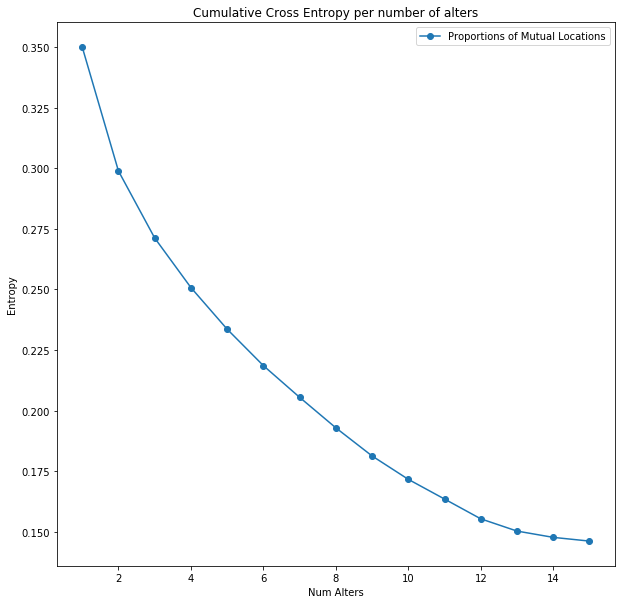

In [95]:
'''Cumulative Cross Entropy of a given Ego'''
fig=plt.figure(figsize=(10, 10))
#plt.plot(np.arange(1,16,1), CCE_All_Avg, '-o', label = 'Average Cumulative Cross Entropy')
plt.plot(np.arange(1,16,1),MutLocs_Avg_0 , '-o', label = 'Proportions of Mutual Locations')
#plt.plot(np.arange(1,16,1), CCE_Temp, '-o', label = 'Temporal Control')
#plt.plot(np.arange(1,16,1), LZUsr1, '--', label = 'Entropy of Ego')
plt.title('Average Proportion of Mutual Locations vs Alter Number')
plt.ylabel('Proportion of Mutual Locations')
plt.xlabel('Num Alters')
plt.legend()
plt.show()

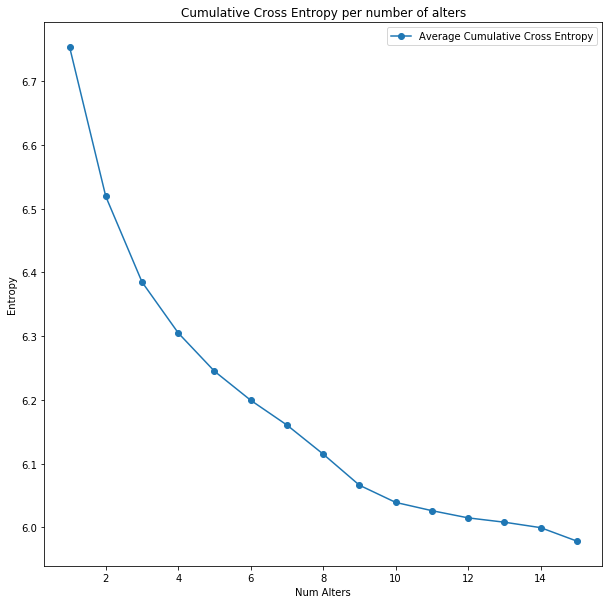

In [96]:
'''Cumulative Cross Entropy of a given Ego'''
fig=plt.figure(figsize=(10, 10))
plt.plot(np.arange(1,16,1), CCE_All_Avg, '-o', label = 'Average Cumulative Cross Entropy')
#plt.plot(np.arange(1,16,1),MutLocs_Avg_0 , '-o', label = 'Proportions of Mutual Locations')
#plt.plot(np.arange(1,16,1), CCE_Temp, '-o', label = 'Temporal Control')
#plt.plot(np.arange(1,16,1), LZUsr1, '--', label = 'Entropy of Ego')
plt.title('Cumulative Cross Entropy per number of alters')
plt.ylabel('Entropy')
plt.xlabel('Num Alters')
plt.legend()
plt.show()

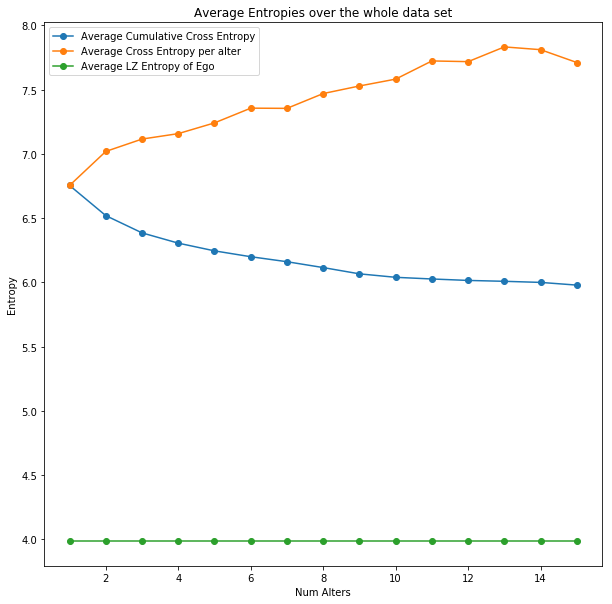

In [165]:
'''Cumulative Cross Entropy of a given Ego'''
fig=plt.figure(figsize=(10, 10))
#plt.plot(np.arange(1,16,1),MutLocs_Avg_0 , '-o', label = 'Proportions of Mutual Locations')
plt.plot(np.arange(1,16,1), CCE_All_Avg, '-o', label = 'Average Cumulative Cross Entropy')
plt.plot(np.arange(1,16,1),LZ_CE_Avg[1:] , '-o', label = 'Average Cross Entropy per alter')
plt.plot(np.arange(1,16,1),[LZ_CE_Avg[0]]*15 , '-o', label = 'Average LZ Entropy of Ego')
#plt.plot(np.arange(1,16,1), CCE_Temp, '-o', label = 'Temporal Control')
#plt.plot(np.arange(1,16,1), LZUsr1, '--', label = 'Entropy of Ego')
plt.title('Average Entropies over the whole data set')
plt.ylabel('Entropy')
plt.xlabel('Num Alters')
plt.legend()
plt.show()

In [91]:
'''Creates Array of tuples between prop of Mut Locs and Cross Entropy '''

CE_MutLocs_Tups = []
for i in range(len(LZ_CrossEntropy)):
    if 0 in MutLocsProportions[i]:
        CE_MutLocs_Tups = CE_MutLocs_Tups + list(zip(LZ_CrossEntropy[i][1:MutLocsProportions[i].index(0)],MutLocsProportions[i][:MutLocsProportions[i].index(0)]))
    else:
        CE_MutLocs_Tups = CE_MutLocs_Tups + list(zip(LZ_CrossEntropy[i][1:],MutLocsProportions[i]))

CE_MutLocs_Tups_Scaled = []
for i in range(len(LZ_CE_Avg)):
    if 0 in MutLocsProportions[i]:
        CE_MutLocs_Tups_Scaled = CE_MutLocs_Tups_Scaled + list(zip(LZ_CE_Avg_0[i][:MutLocsProportions[i].index(0)],MutLocsProportions[i][:MutLocsProportions[i].index(0)]))
    else:
        CE_MutLocs_Tups_Scaled = CE_MutLocs_Tups_Scaled + list(zip(LZ_CE_Avg_0[i],MutLocsProportions[i]))


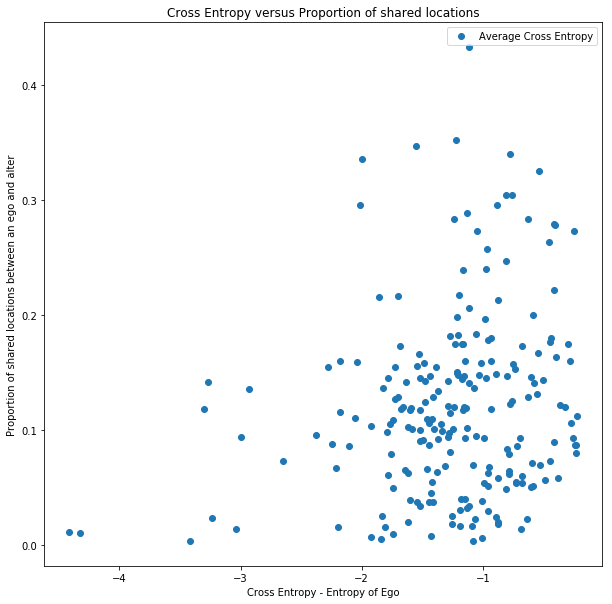

In [94]:
'''Cumulative Cross Entropy of a given Ego'''
fig=plt.figure(figsize=(10, 10))
#plt.plot(list(zip(*CE_MutLocs_Tups))[0], list(zip(*CE_MutLocs_Tups))[1], 'o', label = 'Average Cumulative Cross Entropy')
plt.plot(list(zip(*CE_MutLocs_Tups_Scaled))[0], list(zip(*CE_MutLocs_Tups_Scaled))[1], 'o', label = 'Scaled Cross Entropy')
#plt.plot(np.arange(1,16,1),MutLocs_Avg_0 , '-o', label = 'Proportions of Mutual Locations')
#plt.plot(np.arange(1,16,1), CCE_Temp, '-o', label = 'Temporal Control')
#plt.plot(np.arange(1,16,1), LZUsr1, '--', label = 'Entropy of Ego')
plt.title('Cross Entropy versus Proportion of shared locations')
plt.ylabel('Proportion of shared locations between an ego and alter')
plt.xlabel('Cross Entropy - Entropy of Ego')
plt.legend()
plt.show()

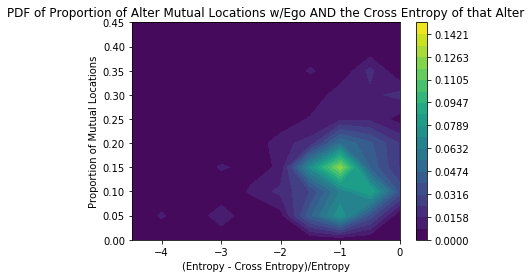

In [178]:
'''2D PDF of PropMutLocs vs Cross Entropy'''
#levs = np.append(0,np.logspace(-5,-.4,20))
levs = np.linspace(0,.15,20)
plt.ylabel('Proportion of Mutual Locations')
plt.xlabel('(Entropy - Cross Entropy)/Entropy')
plt.title('PDF of Proportion of Alter Mutual Locations w/Ego AND the Cross Entropy of that Alter')
Y = np.arange(-.05,.5,.05)
X = np.arange(-5,.5,.5)
X1,Y1 = np.meshgrid(X,Y)
Phi = np.histogram2d(list(zip(*CE_MutLocs_Tups_Scaled))[0],list(zip(*CE_MutLocs_Tups_Scaled))[1],bins = (X,Y))/np.sum(np.histogram2d(list(zip(*CE_MutLocs_Tups_Scaled))[0],list(zip(*CE_MutLocs_Tups_Scaled))[1],bins = (X,Y))[0])
X1.shape
#plt.pcolormesh(X1,Y1,Phi[0].T/Phi[0].sum())
plt.contourf(X1[1:,1:],Y1[1:,1:],Phi[0].T, levs)
#pcm = plt.pcolor(X1, Y1, Phi[0], norm=colors.LogNorm(vmin=0.0001, vmax=1),cmap='PuBu_r')
plt.colorbar()
#plt.zscale('log')

In [112]:
'''List of Cross Entropies of best friend'''
LZ_CrossEntropy_Alter = [LZ_CrossEntropy[x][1] for x in range(len(LZ_CrossEntropy))]

False

In [114]:
'''Histograms'''
LZHist = np.histogram(LZ,bins=20)
ShanHist = np.histogram(Shan,bins=20)
LZ_CrossEntropy_Alter_Hist = np.histogram(LZ_CrossEntropy_Alter,bins=20, range = (2,11))

C:\Users\Sean\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Sean\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


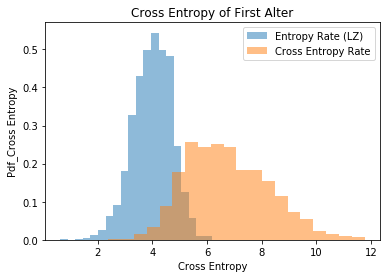

In [168]:
plt.title('Cross Entropy of First Alter')
plt.xlabel('Cross Entropy')
plt.ylabel('Pdf_Cross Entropy')
plt.hist(LZ,bins = 20,density = True, label = 'Entropy Rate (LZ)',alpha=.5)
plt.hist(LZ_CrossEntropy_Alter,bins = 20,density = True, label = 'Cross Entropy Rate',alpha=.5)
#plt.hist(Shan,bins = 20,density = True, label = 'Shannon Entropy',alpha=.5)
plt.legend()
plt.show()

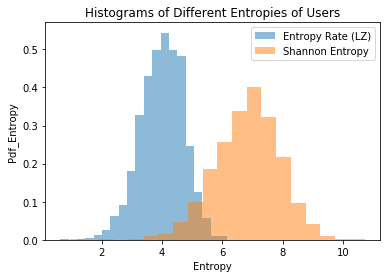

In [33]:
plt.title('Histograms of Different Entropies of Users')
plt.xlabel('Entropy')
plt.ylabel('Pdf_Entropy')
plt.hist(LZ,bins = 20,density = True, label = 'Entropy Rate (LZ)',alpha=.5)
plt.hist(Shan,bins = 20,density = True, label = 'Shannon Entropy',alpha=.5)
plt.legend()
plt.show()

In [62]:
TopFriendsUsr1 = topFriends(usrsMut[1])

In [63]:
CCE = CrossEntropy_Time2(usrsMut[1],TopFriendsUsr1[:15])
CCEwEgo = CrossEntropy_Time2(usrsMut[1],TopFriendsUsr1[:15],with_ego=True)
CCE_Temp = CrossEntropy_Time2(usrsMut[1],TopFriendsUsr1[:15],temporal_control = True)

wungjae-hyun
4280
jp-kim
sunghwan-kim
siegfrid
keynas-jeong
golee
minsu-ju
yoon-moung-hee
sutae-kim
jihoon-yeo
tj-cho
dylan-ko
jjangmi
hongje-lee
0
[431]
[2990]
2990.0
[1104]
1
[431, 269]
[2990, 2685]
2872.792857142857
[1104, 942]
2
[431, 269, 158]
[2990, 2685, 3765]
3037.0920745920744
[1104, 942, 831]
3
[431, 269, 158, 212]
[2990, 2685, 3765, 1020]
2637.4439252336447
[1104, 942, 831, 885]
4
[431, 269, 158, 212, 93]
[2990, 2685, 3765, 1020, 3730]
2724.810834049871
[1104, 942, 831, 885, 766]
5
[431, 269, 158, 212, 93, 82]
[2990, 2685, 3765, 1020, 3730, 1485]
2643.152610441767
[1104, 942, 831, 885, 766, 755]
6
[431, 269, 158, 212, 93, 82, 99]
[2990, 2685, 3765, 1020, 3730, 1485, 3072]
2674.7418154761904
[1104, 942, 831, 885, 766, 755, 772]
7
[431, 269, 158, 212, 93, 82, 99, 186]
[2990, 2685, 3765, 1020, 3730, 1485, 3072, 896]
2458.502614379085
[1104, 942, 831, 885, 766, 755, 772, 859]
8
[431, 269, 158, 212, 93, 82, 99, 186, 63]
[2990, 2685, 3765, 1020, 3730, 1485, 3072, 896, 378]
2376.22

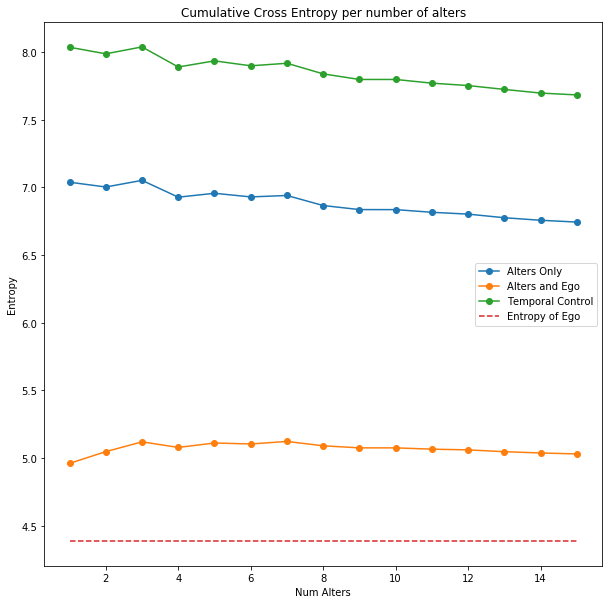

In [72]:
'''Cumulative Cross Entropy of a given Ego'''
fig=plt.figure(figsize=(10, 10))
plt.plot(np.arange(1,16,1), CCE, '-o', label = 'Alters Only ')
plt.plot(np.arange(1,16,1), CCEwEgo, '-o', label = 'Alters and Ego')
plt.plot(np.arange(1,16,1), CCE_Temp, '-o', label = 'Temporal Control')
plt.plot(np.arange(1,16,1), LZUsr1, '--', label = 'Entropy of Ego')
plt.title('Cumulative Cross Entropy per number of alters')
plt.ylabel('Entropy')
plt.xlabel('Num Alters')
plt.legend()
plt.show()